# Belgian production network model

## Prototyping

*Original code by Cyril Garneau. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2022 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [3]:
from covid19model.models.ODE_models import Economic_Model
from covid19model.data.economic import get_sector_labels, get_model_parameters, aggregate_simulation
from covid19model.data.economic import get_sectoral_conversion_matrix as get_convmat
from covid19model.models.economic_utils import *
from covid19model.models.time_dependant_parameter_fncs import *

In [4]:
from covid19model.data.economic import get_revenue_survey, get_employment_survey, get_synthetic_GDP, get_B2B_demand

In [5]:
data_employment = get_employment_survey()
data_revenue = get_revenue_survey()
data_GDP = get_synthetic_GDP()
data_B2B_demand = get_B2B_demand()

### B2B Payment data

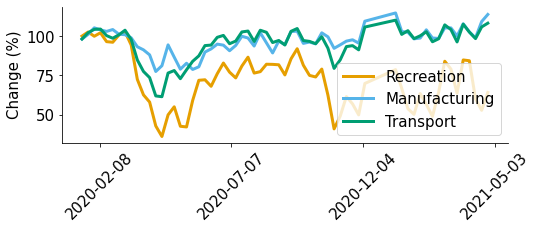

In [6]:
fig,ax=plt.subplots(figsize=(8,2.5))
copy_df = data_B2B_demand.loc[slice('2017-01-01',None)]
ax.plot(copy_df.loc[slice(None), 'R'].rolling(window=2).mean(), label='Recreation')
ax.plot(copy_df.loc[slice(None), 'C'].rolling(window=2).mean(), label='Manufacturing')
ax.plot(copy_df.loc[slice(None), 'H'].rolling(window=2).mean(), label='Transport')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel('Change (%)')
ax.legend()
ax.grid(False)

### Revenue survey data

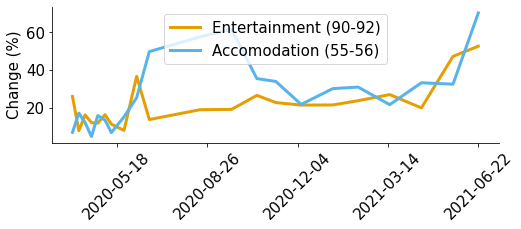

In [7]:
fig,ax=plt.subplots(figsize=(8,2.5))
ax.plot(data_revenue.loc[slice(None), '90-92']*100, label='Entertainment (90-92)')
ax.plot(data_revenue.loc[slice(None), '55-56']*100, label='Accomodation (55-56)')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel('Change (%)') 
ax.legend()
ax.grid(False)

### GDP data

Index(['10-12', '13-15', '17', '20', '22', '24', '25', '26', '27', '28', '29',
       '30', '41-43', '45', '49', '50', '51', '52', '53', '62-63', '77', 'BE'],
      dtype='object', name='NACE64')


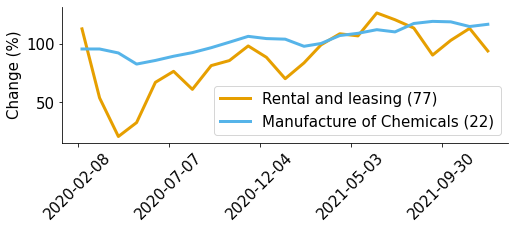

In [8]:
print(data_GDP.index.get_level_values('NACE64').unique())

fig,ax=plt.subplots(figsize=(8,2.5))
ax.plot(data_GDP.loc[slice(None), '77']*100, label='Rental and leasing (77)')
ax.plot(data_GDP.loc[slice(None), '20']*100, label='Manufacture of Chemicals (22)')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel('Change (%)') 
ax.legend()
ax.grid(False)

## Setup model

In [9]:
# Load the parameters using `get_economic_parameters()`.
params = get_model_parameters()

# Parameters
# ----------
start_date = '2020-03-01'
end_date = '2021-01-01'
t_start_lockdown = pd.Timestamp('2020-03-10')
t_end_lockdown =pd.Timestamp('2020-05-04')
t_end_pandemic = pd.Timestamp('2020-10-01')
                    
params.update({'rho': 1-(1-0.6)/90, # Economic recovery time (0.6 quarters?)
               'delta_S': 0.5, # household savings rate (delta_S = 1; households save all money they are not spending due to shock)
               'L': 0.5, # Fraction of population believing in L-shaped recovery
               'l_start_lockdown': sum((1-params['l_s'])*params['l_0']), # Verify this must be the sum
               'zeta': 1,
               'tau': 10, # Restock rate (days)
               'gamma_F': 1/7, # Firing rate (days-1)
               'gamma_H': 1/28 }) # Hiring rate (days-1)


# Time-dependent parameters
# -------------------------
params.update({'epsilon_S': np.zeros([params['c_s'].shape[0]]),
                'epsilon_D': np.zeros([params['c_s'].shape[0]]),
                'epsilon_F': np.zeros([params['c_s'].shape[0]]),
                't_start_lockdown': t_start_lockdown,
                't_end_lockdown': t_end_lockdown,
                't_end_pandemic': t_end_pandemic,
                'b': 1,
                'b_s': 1,
                't_start_compensation': t_start_lockdown,
                't_end_compensation': t_end_pandemic})

# Load initial states
initial_states = {'x': params['x_0'],
                  'c': params['c_0'],
                  'c_desired': params['c_0'],
                  'f': params['f_0'],
                  'd': params['x_0'],
                  'l': params['l_0'],
                  'O': params['O_j'],
                  'S': params['S_0']}

coordinates = {'NACE64': get_sector_labels('NACE64')}
time_dependent_parameters = {'epsilon_S': labor_supply_shock,
                             'epsilon_D': household_demand_shock,
                             'epsilon_F': other_demand_shock,
                             'b': government_furloughing,
                             'zeta': compute_income_expectations}

# Initialize the model
model = Economic_Model(initial_states, params, coordinates=coordinates, time_dependent_parameters=time_dependent_parameters)

/home/twallema/Documents/PhD/Corona/Python/git/COVID19-Model/src/covid19model/models/economic_utils.py:48: RuntimeWarning: invalid value encountered in true_divide
  x_t[i] = np.nanmin(S_t[np.where(C[:,i] == 1),i]/A[np.where(C[:,i] == 1),i])
/home/twallema/Documents/PhD/Corona/Python/git/COVID19-Model/src/covid19model/models/economic_utils.py:48: RuntimeWarning: All-NaN slice encountered
  x_t[i] = np.nanmin(S_t[np.where(C[:,i] == 1),i]/A[np.where(C[:,i] == 1),i])


## Simulate

In [10]:
out=model.sim([start_date, end_date])
simtime = out['date'].values

## Illustrate household demand shock

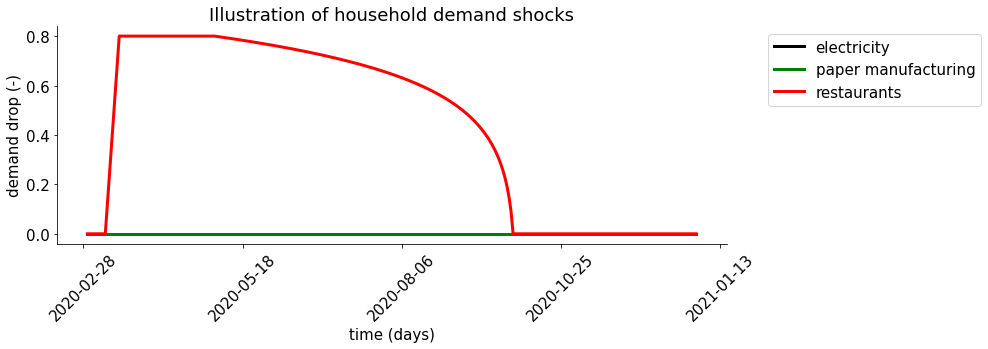

In [11]:
for idx,time in enumerate(simtime):
    epsilon_t = household_demand_shock(time,{}, params['epsilon_D'], params['t_start_lockdown'], params['t_end_lockdown'], params['t_end_pandemic'], params['c_s'], params['on_site'])
    if idx == 0:
        epsilon = np.expand_dims(epsilon_t,axis=1)
    else:
        epsilon = np.append(epsilon, np.expand_dims(epsilon_t,axis=1), axis=1)

fig,ax = plt.subplots(figsize=(12,4))
plottime = 600
ax.plot(simtime,epsilon[23,:],color='black')
ax.plot(simtime,epsilon[7,:],color='green')
ax.plot(simtime,epsilon[-28,:],color='red')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_title('Illustration of household demand shocks')
ax.set_xlabel('time (days)')
ax.set_ylabel('demand drop (-)')
lgd=ax.legend(['electricity','paper manufacturing','restaurants'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(False)
fig.savefig('demand_shocks.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

## Illustrate long-term expectation of income

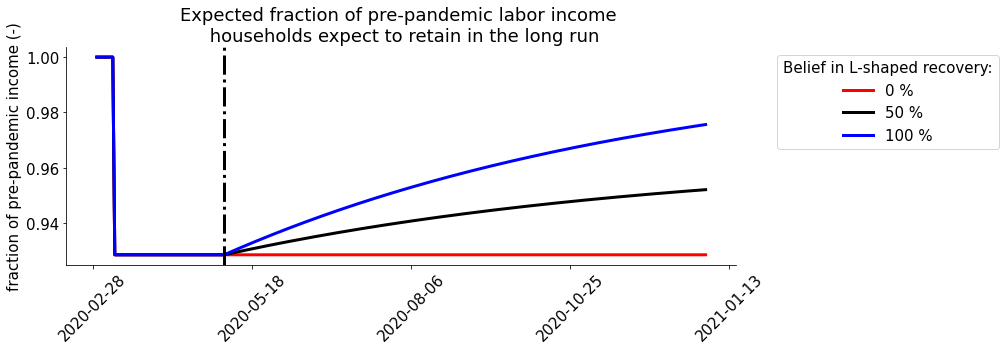

In [12]:
fig,ax = plt.subplots(figsize=(12,4))

color=['red','black','blue']
i=0
for L in [0,0.5,1]:
    zeta=[]
    for time in simtime:
        zeta.append(compute_income_expectations(time,{},{},params['t_start_lockdown'],params['t_end_lockdown'],params['l_0'],params['l_start_lockdown'],params['rho'],L))
    ax.plot(simtime,zeta,color=color[i])
    i=i+1
    
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.axvline(params['t_end_lockdown'],color='black',ls='-.')
ax.set_title('Expected fraction of pre-pandemic labor income \n households expect to retain in the long run')
ax.set_ylabel('fraction of pre-pandemic income (-)')
lgd=ax.legend(['0 %','50 %', '100 %'],bbox_to_anchor=(1.05, 1), loc='upper left',title='Belief in L-shaped recovery:')
ax.grid(False)
fig.savefig('l_p.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

## Simulation results

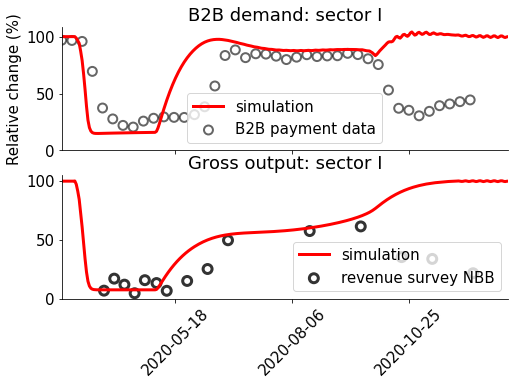

In [27]:
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(8,5), sharex=True)

sector = 'I'

ax1.set_title(f'B2B demand: sector {sector}')
ax1.plot(simtime,aggregate_simulation(out['O'], 'NACE21').sel(NACE21=sector)/aggregate_simulation(out['O'], 'NACE21').sel(NACE21=sector).isel(date=0)*100,color='red', label='simulation')
copy_df = data_B2B_demand.loc[slice('2017-01-01',None)]
ax1.scatter(copy_df.index.get_level_values('date').unique(), copy_df.loc[slice(None), sector].rolling(window=2).mean(), color='black', alpha=0.6, linestyle='None', facecolors='none', s=80, linewidth=2, label='B2B payment data')
ax1.legend()
ax1.set_ylabel('Relative change (%)')
ax1.set_ylim([0,None])
ax1.set_xlim([pd.Timestamp(start_date), pd.Timestamp(end_date)])
ax1.grid(False)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

sector_NACE64 = '55-56'
ax2.set_title(f'Gross output: sector {sector}')
ax2.plot(simtime,aggregate_simulation(out['x'], 'NACE21').sel(NACE21=sector)/aggregate_simulation(out['x'], 'NACE21').sel(NACE21=sector).isel(date=0)*100,color='red', label='simulation')
ax2.scatter(data_revenue.loc[slice(None), sector_NACE64].index.get_level_values('date').unique(), data_revenue.loc[slice(None), sector_NACE64]*100, color='black', alpha=0.8, linestyle='None', facecolors='none', s=80, linewidth=3, label='revenue survey NBB')
ax2.legend()
ax2.set_ylim([0,None])
ax2.grid(False)
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
    
plt.show()
plt.close()

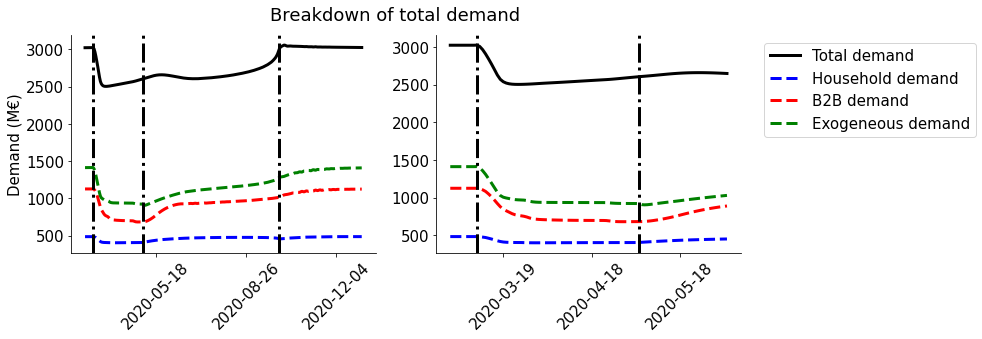

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
fig.suptitle('Breakdown of total demand')

ax1.plot(simtime,out['d'].sum(dim='NACE64'),color='black')
ax1.plot(simtime,out['c'].sum(dim='NACE64'),color='blue',ls='--')
ax1.plot(simtime,out['O'].sum(dim='NACE64'),color='red',ls='--')
ax1.plot(simtime,out['f'].sum(dim='NACE64'),color='green',ls='--')
ax1.axvline(t_start_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_pandemic,color='black',linestyle='-.')
ax1.set_ylabel('Demand (M€)')
ax1.grid('on')
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.grid(False)

ax2.plot(out['date'].sel(date=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),out['d'].sum(dim='NACE64').sel(date=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),color='black')
ax2.plot(out['date'].sel(date=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),out['c'].sum(dim='NACE64').sel(date=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),color='blue',ls='--')
ax2.plot(out['date'].sel(date=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),out['O'].sum(dim='NACE64').sel(date=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),color='red',ls='--')
ax2.plot(out['date'].sel(date=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),out['f'].sum(dim='NACE64').sel(date=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),color='green',ls='--')
ax2.axvline(t_start_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_lockdown,color='black',linestyle='-.')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
lgd=ax2.legend(['Total demand','Household demand','B2B demand','Exogeneous demand'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(False)
plt.show()

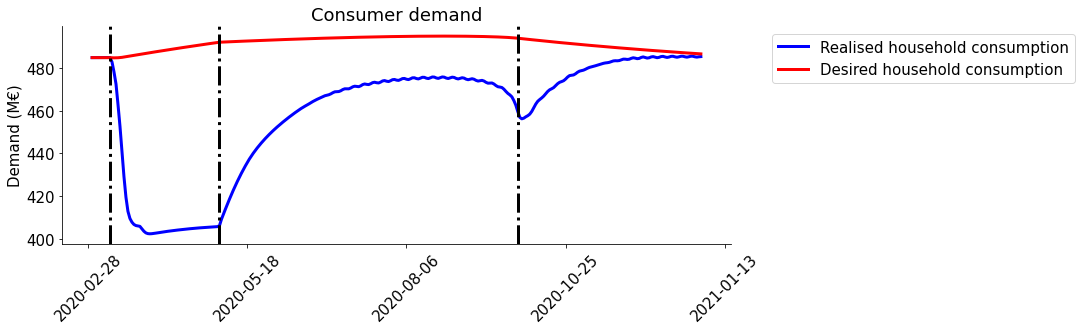

In [15]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(simtime,out['c'].sum(dim='NACE64'),color='blue')
ax.plot(simtime,out['c_desired'].sum(dim='NACE64'),color='red')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Consumer demand')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel('Demand (M€)')
lgd=ax.legend(['Realised household consumption','Desired household consumption'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(False)
plt.show()

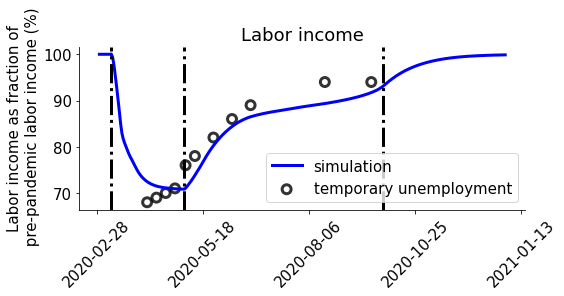

In [16]:
fig,ax=plt.subplots(figsize=(8,3))
ax.plot(simtime,(out['l'].sum(dim='NACE64')/np.sum(params['l_0'],axis=0)*100), color='blue', label='simulation')
ax.scatter(data_employment.loc[slice(None,t_end_pandemic), 'BE'].index.get_level_values('date').unique(), data_employment.loc[slice(None,t_end_pandemic), 'BE']*100, color='black', alpha=0.8, linestyle='None', facecolors='none', s=80, linewidth=3, label='temporary unemployment')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.legend()
ax.set_title('Labor income')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel('Labor income as fraction of\n pre-pandemic labor income (%)')
ax.grid(False)
plt.show()

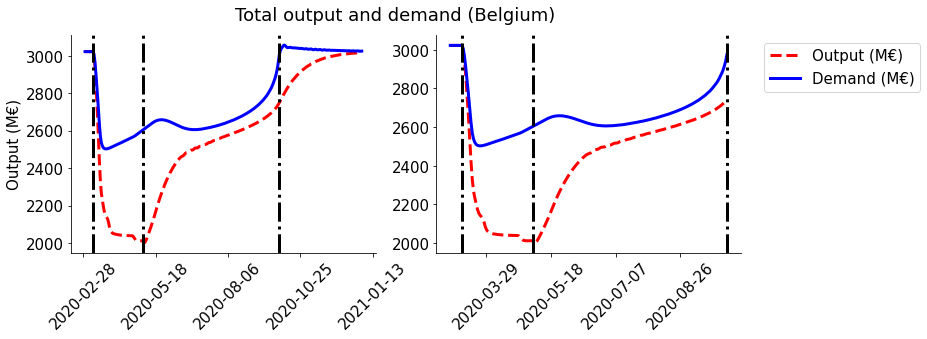

In [17]:
fig,(ax1,ax2)=plt.subplots(1, 2,figsize=(12,4))

fig.suptitle('Total output and demand (Belgium)')
ax1.plot(simtime,out['x'].sum(dim='NACE64'),color='red',ls='--')
ax1.plot(simtime,out['d'].sum(dim='NACE64'),color='blue')
ax1.axvline(t_start_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_pandemic,color='black',linestyle='-.')
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_ylabel('Output (M€)')
ax1.grid(False)

ax2.plot(out['date'].sel(date=slice(start_date, t_end_pandemic)),out['x'].sum(dim='NACE64').sel(date=slice(start_date, t_end_pandemic)),color='red',ls='--')
ax2.plot(out['date'].sel(date=slice(start_date, t_end_pandemic)),out['d'].sum(dim='NACE64').sel(date=slice(start_date, t_end_pandemic)),color='blue')
ax2.axvline(t_start_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_pandemic,color='black',linestyle='-.')
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
lgd=ax2.legend(['Output (M€)','Demand (M€)'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(False)
plt.show()

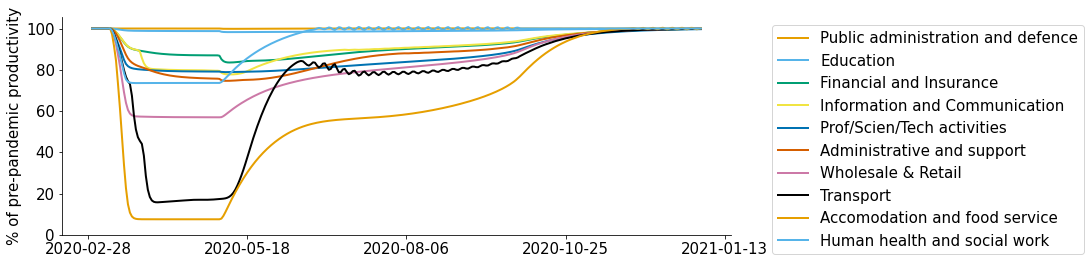

In [24]:
classification = 'NACE21'
sectors = ['O', 'P', 'K', 'J', 'M', 'N', 'G', 'H', 'I', 'Q']
sectors_name = ['Public administration and defence', 'Education', 'Financial and Insurance',
                'Information and Communication', 'Prof/Scien/Tech activities', 'Administrative and support',
                'Wholesale & Retail', 'Transport', 'Accomodation and food service', 'Human health and social work']
x = aggregate_simulation(out['x'], classification)

fig,ax=plt.subplots(figsize=(12,4))
for sector in sectors:
    ax.plot(simtime,x.sel({classification: sector})/x.sel({classification: sector}).isel(date=0)*100,linewidth=2, alpha=1)

ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.grid(False)
ax.set_ylabel('% of pre-pandemic productivity')
ax.legend(sectors_name,bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim([0,None])
fig.savefig('labor_breakdown_NACE10.jpg',dpi=400, bbox_inches='tight')
plt.show()
plt.close()

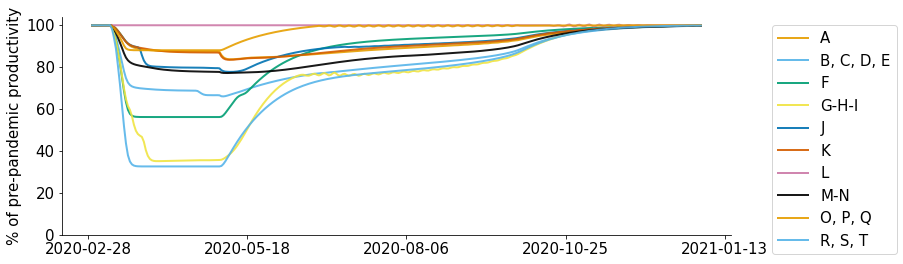

In [19]:
classification = 'NACE10'
x = aggregate_simulation(out['x'], classification)

fig,ax=plt.subplots(figsize=(12,4))
for sector in x.coords[classification].values:
    ax.plot(simtime,x.sel({classification: sector})/x.sel({classification: sector}).isel(date=0)*100,linewidth=2, alpha=0.9)

ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.grid(False)
ax.set_ylabel('% of pre-pandemic productivity')
ax.legend(x.coords[classification].values,bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim([0,None])
fig.savefig('labor_breakdown_NACE10.jpg',dpi=400, bbox_inches='tight')
plt.show()

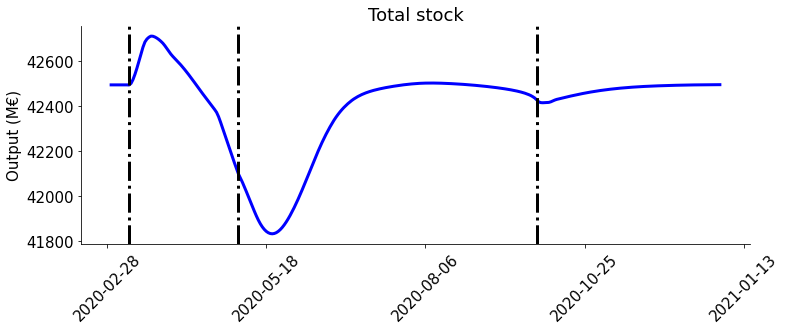

In [20]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(simtime,out['S'].sum(dim='NACE64').sum(dim='NACE64'),color='blue')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Total stock')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel('Output (M€)')
ax.grid(False)
plt.show()

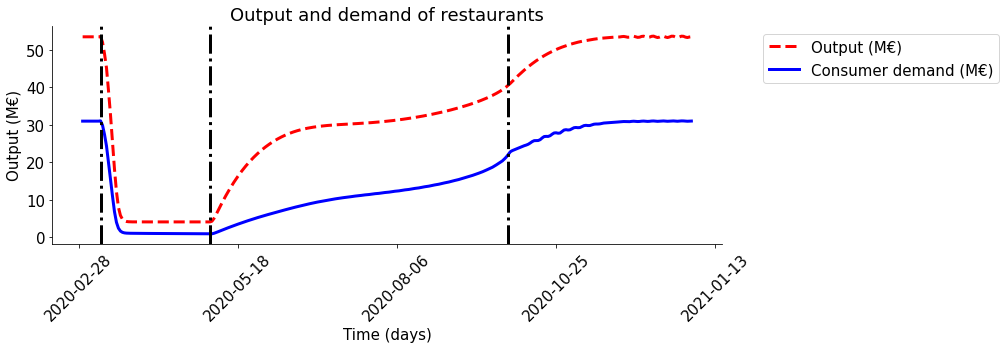

In [21]:
fig,ax=plt.subplots(figsize=(12,4))

ax.plot(simtime,out['x'][-28,:],color='red',ls='--', label='Output (M€)')
ax.plot(simtime,out['c'][-28,:],color='blue', label='Consumer demand (M€)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Output and demand of restaurants')

ax.set_xlabel('Time (days)')
ax.set_ylabel('Output (M€)')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.grid(False)
plt.show()

## To labor shock or not to labor shock

In [22]:
params.update({'l_s': np.zeros(63)})
model = Economic_Model(initial_states, params, coordinates=coordinates,
                              time_dependent_parameters={'epsilon_S': labor_supply_shock,
                                                         'epsilon_D': household_demand_shock,
                                                         'epsilon_F': other_demand_shock,
                                                         'b': government_furloughing,
                                                         'zeta': compute_income_expectations})
out_no_labor_shock = model.sim([start_date, end_date])

/home/twallema/Documents/PhD/Corona/Python/git/COVID19-Model/src/covid19model/models/economic_utils.py:48: RuntimeWarning: invalid value encountered in true_divide
  x_t[i] = np.nanmin(S_t[np.where(C[:,i] == 1),i]/A[np.where(C[:,i] == 1),i])
/home/twallema/Documents/PhD/Corona/Python/git/COVID19-Model/src/covid19model/models/economic_utils.py:48: RuntimeWarning: All-NaN slice encountered
  x_t[i] = np.nanmin(S_t[np.where(C[:,i] == 1),i]/A[np.where(C[:,i] == 1),i])


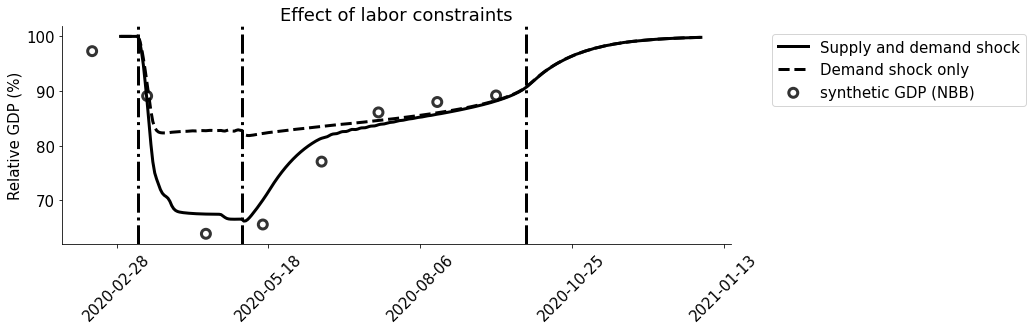

In [23]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(simtime,out['x'].sum(dim='NACE64')/out['x'].sum(dim='NACE64').sel(date=simtime[0])*100,color='black',label='Supply and demand shock')
ax.plot(out_no_labor_shock['date'],out_no_labor_shock['x'].sum(dim='NACE64')/out['x'].sum(dim='NACE64').sel(date=simtime[0])*100,color='black',ls='--',label='Demand shock only')
ax.scatter(data_GDP.loc[slice(None,t_end_pandemic), 'BE'].index.get_level_values('date').unique(), data_GDP.loc[slice(None,t_end_pandemic), 'BE']*100, color='black', alpha=0.8, linestyle='None', facecolors='none', s=80, linewidth=3, label='synthetic GDP (NBB)')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Effect of labor constraints')
ax.set_ylabel('Relative GDP (%)')
lgd=ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(False)
plt.show()